# Importing Modules

In [ ]:
# our basic libraries
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
 
from __future__ import print_function, division
import os
 
# data loading and transforming
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torch.optim as optim 
 
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 

plt.ion()   # interactive mode

## Checking hardware and cuda support

In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
torch.cuda.empty_cache()
cuda0 = torch.device('cuda:0')
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))

1
GeForce GTX 1060 6GB
Torch 1.7.0 CUDA 10.1
Device: cuda:0


### Loading Data
a. Load train and test datasets here: https://ai.stanford.edu/~jkrause/cars/car_dataset.html 
   Read the paper to get some insights: https://ai.stanford.edu/~jkrause/papers/3drr13.pdf 

In [ ]:
#DATA_FOLDER = "/content/drive/MyDrive/ColabNotebooks/bds/cnn/cars196/car_data/car_data"
DATA_FOLDER = "c:/car_data/"

#CSV_TRAIN = "/content/drive/MyDrive/ColabNotebooks/bds/cnn/cars196/car_data/anno_train.csv"
#CSV_TEST = "/content/drive/MyDrive/ColabNotebooks/bds/cnn/cars196/car_data/anno_test.csv"

#### b. Standardize the data (0...1 range instead of 0..255)

###### To standartizise we use method ToTensor() in transfomation section

In [ ]:
data_transform_train = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.ToTensor()
    ])
data_transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
        
batch_size = 16

cars_dataset_train = datasets.ImageFolder(root=DATA_FOLDER+'/train',
                                           transform=data_transform_train)
cars_dataset_test = datasets.ImageFolder(root=DATA_FOLDER+'/test',
                                           transform=data_transform_test)

train_loader = torch.utils.data.DataLoader(cars_dataset_train,
                                             batch_size, shuffle=True, num_workers=16)
test_loader = torch.utils.data.DataLoader(cars_dataset_test,
                                             batch_size, shuffle=True, num_workers=16)

In [ ]:
print('Train data, number of images: ', len(cars_dataset_train))
print('Test data, number of images: ', len(cars_dataset_test))

Train data, number of images:  8144
Test data, number of images:  8041


In [ ]:
# specify the image classes
classes = cars_dataset_train.classes

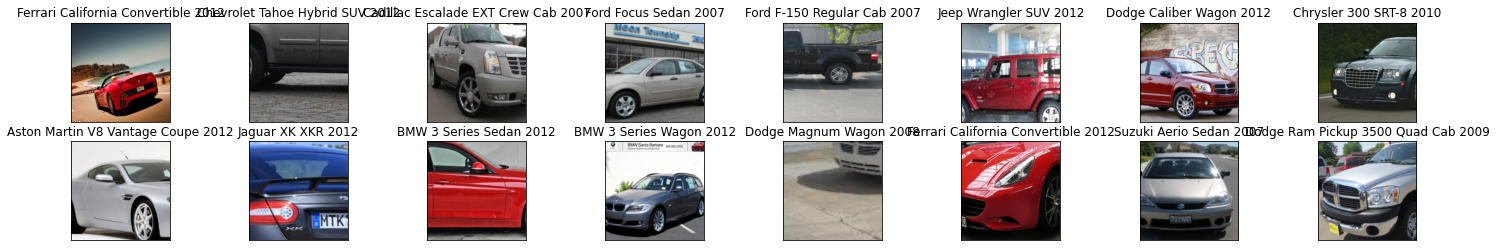

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy().transpose((0, 2, 3, 1))
#images = np.clip(images, 0, 1)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

In [ ]:
def accuracy_before_training(model):
    # Calculate accuracy before training
    correct = 0
    total = 0

    # Iterate through test dataset
    for images, labels in test_loader:  # DataLoader - test

        images = images.to(cuda0)
        # forward pass to get outputs
        # the outputs are a series of class scores
        outputs = model(images)
        #outputs= outputs  # (20, 10)
        labels = labels.to(cuda0)
        # get the predicted class from the maximum value in the output-list of class scores
        _, predicted = torch.max(outputs.data, 1)

        # count up total number of correct labels
        # for which the predicted and true labels are equal
        total += labels.size(0)
        correct += (predicted == labels).sum()

    # calculate the accuracy
    # to convert `correct` from a Tensor into a scalar, use .item()
    accuracy = 100.0 * correct.item() / total

    # print it out!
    print('Accuracy before training: ', accuracy)

Defining some functions before training

In [ ]:
def accuracyOnTestModel(Model):
    # initialize tensor and lists to monitor test loss and accuracy
    correct = 0.0
    total = 0.0

    # set the module to evaluation mode
    Model.eval().to(cuda0)

    for batch_i, data in enumerate(test_loader):
        images, labels = data
        #images = images.to(device).half() # uncomment for half precision model
        images = images.to(cuda0)
        labels = labels.to(cuda0)

        outputs = Model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: ' +str(test_acc))
    return test_acc

In [ ]:
def accuracyOnTrainModel(Model):
    # initialize tensor and lists to monitor test loss and accuracy
    correct = 0.0
    total = 0.0

    # set the module to evaluation mode
    Model.eval().to(cuda0)

    for batch_i, data in enumerate(train_loader):
        images, labels = data
        #images = images.to(device).half() # uncomment for half precision model
        images = images.to(cuda0)
        labels = labels.to(cuda0)

        outputs = Model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the train images: ' +str(test_acc))
    return test_acc

#### с. Define custom Convolutional neural network with 1, 2, 3, 4 Conv2D and pooling layers. Train and evaluate the models.
#### d. Visualize training results (train/test accuracy and loss)

In [ ]:
# nn with 1 Conv2D layer

class Net1Conv2d(nn.Module):

    def __init__(self):
        super(Net1Conv2d, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(394272, 1024)
        #self.fc1_drop = nn.Dropout(p=0.4)
       
        self.fc2 = nn.Linear(1024, 196)

    # define the feedforward behavior
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))

        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        #x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # final output
        return x

# instantiate and print your Net
Net1Conv2dModel = Net1Conv2d().to(cuda0)
print(Net1Conv2dModel)

In [ ]:
#accuracy_before_training(Net1Conv2d)

In [ ]:
def train(n_ep, model):

    
    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    loss_over_time = [] # to track the loss as the network trains
    
    for epoch in range(n_ep):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for batch_i, data in enumerate(train_loader):  # DataLoader - train
            # get the input images and their corresponding labels
            inputs, labels = data

            inputs = inputs.to(cuda0)
            labels = labels.to(cuda0)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            outputs = model(inputs)  # (20, 10)

            # calculate the loss
            loss = criterion(outputs, labels)  # (y^, y) = (predicted, true)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            
            if batch_i % 100 == 99:    # print every 1000 batches
                avg_loss = running_loss/100
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, avg_loss))
                running_loss = 0.0

    print('Finished Training')
    return loss_over_time


In [ ]:
def trainModel(model, n_epochs):
    training_loss = train(n_epochs, model)
    
    plt.plot(training_loss)
    plt.xlabel('100\'s of batches')
    plt.ylabel('loss with '+model.__class__.__name__)
    plt.ylim(0, 6) # consistent scale
    plt.show()
    
    a_test = accuracyOnTrainModel(model)
    a_train = accuracyOnTestModel(model)
    
    return training_loss, a_test, a_train
    

In [ ]:
epochs_baseline = 40

In [ ]:
loss_model1, accur_test_model1, accur_train_model1 = trainModel(Net1Conv2dModel, n_epochs=epochs_baseline)

RuntimeError: CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 6.00 GiB total capacity; 4.52 GiB already allocated; 73.72 MiB free; 4.54 GiB reserved in total by PyTorch)

In [ ]:
# nn with 2 Conv2D layer

class Net2Conv2d(nn.Module):

    def __init__(self):
        super(Net2Conv2d, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(186624, 1024)
        #self.fc1_drop = nn.Dropout(p=0.4)
       
        self.fc2 = nn.Linear(1024, 196)

    # define the feedforward behavior
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))    
        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        #x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # final output
        return x

# instantiate and print your Net
Net2Conv2dModel = Net2Conv2d().to(cuda0)
print(Net2Conv2dModel)

In [ ]:
loss_model2, accur_test_model2, accur_train_model2 = trainModel(Net2Conv2dModel, n_epochs=epochs_baseline)

In [ ]:
# nn with 3 Conv2D layer

class Net3Conv2d(nn.Module):

    def __init__(self):
        super(Net3Conv2d, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(86528, 1024)
        #self.fc1_drop = nn.Dropout(p=0.4)
       
        self.fc2 = nn.Linear(1024, 196)

    # define the feedforward behavior
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))    
        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        #x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # final output
        return x

# instantiate and print your Net
Net3Conv2dModel = Net3Conv2d().to(cuda0)
print(Net3Conv2dModel)

In [ ]:
loss_model3, accur_test_model3, accur_train_model3 = trainModel(Net3Conv2dModel, n_epochs=epochs_baseline)

In [ ]:
# nn with 4 Conv2D layer

class Net4Conv2d(nn.Module):

    def __init__(self):
        super(Net4Conv2d, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 3)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(36864, 1024)
        #self.fc1_drop = nn.Dropout(p=0.4)
       
        self.fc2 = nn.Linear(1024, 196)

    # define the feedforward behavior
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x))) 
        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        #x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # final output
        return x

# instantiate and print your Net
Net4Conv2dModel = Net4Conv2d().to(cuda0)
print(Net4Conv2dModel)

In [ ]:
loss_model4, accur_test_model4, accur_train_model4 = trainModel(Net4Conv2dModel, n_epochs=epochs_baseline)

In [ ]:
# Saving models
torch.save(Net1Conv2dModel, DATA_FOLDER+'models/Net1Conv2dModel.pth')
torch.save(Net2Conv2dModel, DATA_FOLDER+'models/Net2Conv2dModel.pth')
torch.save(Net3Conv2dModel, DATA_FOLDER+'models/Net3Conv2dModel.pth')
torch.save(Net4Conv2dModel, DATA_FOLDER+'models/Net4Conv2dModel.pth')

In [ ]:
# loading models
'''
Net1Conv2dModel = torch.load(DATA_FOLDER+'models/Net1Conv2dModel.pth')
Net1Conv2dModel.eval()
Net2Conv2dModel = torch.load(DATA_FOLDER+'models/Net2Conv2dModel.pth')
Net2Conv2dModel.eval()
Net3Conv2dModel = torch.load(DATA_FOLDER+'models/Net3Conv2dModel.pth')
Net3Conv2dModel.eval()
Net4Conv2dModel = torch.load(DATA_FOLDER+'models/Net4Conv2dModel.pth')
Net4Conv2dModel.eval()
'''

In [ ]:
# dictionary of lists  
dict_loss_1 = {'Net1Conv2dModel': loss_model1,
               'Net2Conv2dModel': loss_model2,
               'Net3Conv2dModel': loss_model3,
               'Net4Conv2dModel': loss_model4}  
    
loss_stock_models = pd.DataFrame(dict_loss_1) 
loss_stock_models

In [ ]:
loss_stock_models.to_csv(DATA_FOLDER+r'models/loss_stock_models.csv', index=False, header=True)

In [ ]:
load_stock = pd.read_csv(DATA_FOLDER+'models/loss_stock_models.csv')
load_stock

,Net1Conv2dModel,Net2Conv2dModel,Net3Conv2dModel,Net4Conv2dModel
0,5.309014,5.284152,5.279911,5.278451
1,5.278238,5.278417,5.279291,5.278705
2,5.276094,5.278715,5.279190,5.279099
3,5.273568,5.278240,5.279639,5.278597
4,5.272370,5.278294,5.279878,5.278916
...,...,...,...,...
495,3.319629,2.848049,3.031948,3.841046
496,3.423915,2.835256,3.150292,3.850702
497,3.412780,2.893355,3.121899,3.983752
498,3.524348,2.876256,3.217495,3.779248


In [ ]:
# dictionary of lists  
dict_accu_1 = [{'Net1Conv2dModel': accur_train_model1,
               'Net2Conv2dModel': accur_train_model2,
               'Net3Conv2dModel': accur_train_model3,
               'Net4Conv2dModel': accur_train_model4},
               
               {'Net1Conv2dModel': accur_test_model1,
               'Net2Conv2dModel': accur_test_model2,
               'Net3Conv2dModel': accur_test_model3,
               'Net4Conv2dModel': accur_test_model4}]


accu_stock_models = pd.DataFrame(dict_accu_1)

accu_stock_models.to_csv(DATA_FOLDER+r'models/accu_stock_models.csv', index=False, header=True)


In [ ]:
accu_stock_models = pd.read_csv(DATA_FOLDER+'models/accu_stock_models.csv')
accu_stock_models

,Net1Conv2dModel,Net2Conv2dModel,Net3Conv2dModel,Net4Conv2dModel
0,7.188161,7.785101,7.461758,6.951872
1,31.090373,45.211198,39.403242,22.163556


#### d. Visualize training results (train/test accuracy and loss)

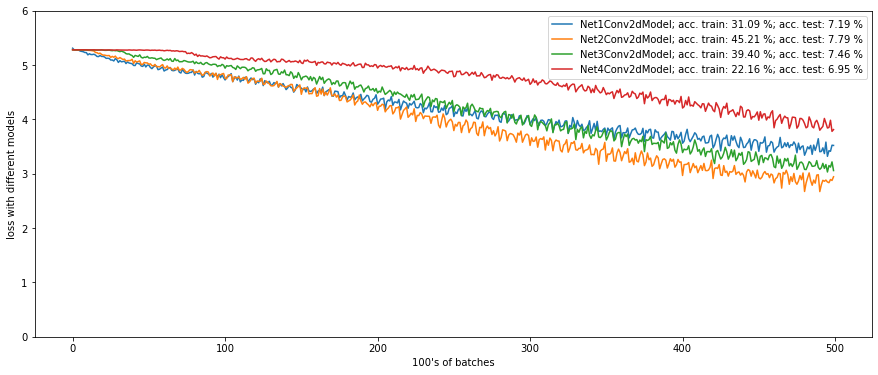

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(load_stock['Net1Conv2dModel'], label='Net1Conv2dModel' + '; acc. train: {:0.2f} %'.format(accu_stock_models['Net1Conv2dModel'][1])+'; acc. test: {:0.2f} %'.format(accu_stock_models['Net1Conv2dModel'][0]))
plt.plot(load_stock['Net2Conv2dModel'], label="Net2Conv2dModel" + '; acc. train: {:0.2f} %'.format(accu_stock_models['Net2Conv2dModel'][1])+'; acc. test: {:0.2f} %'.format(accu_stock_models['Net2Conv2dModel'][0]))
plt.plot(load_stock['Net3Conv2dModel'], label="Net3Conv2dModel" + '; acc. train: {:0.2f} %'.format(accu_stock_models['Net3Conv2dModel'][1])+'; acc. test: {:0.2f} %'.format(accu_stock_models['Net3Conv2dModel'][0]))
plt.plot(load_stock['Net4Conv2dModel'], label="Net4Conv2dModel" + '; acc. train: {:0.2f} %'.format(accu_stock_models['Net4Conv2dModel'][1])+'; acc. test: {:0.2f} %'.format(accu_stock_models['Net4Conv2dModel'][0]))
plt.xlabel('100\'s of batches')
plt.ylabel('loss with different models')
plt.ylim(0, 6) # consistent scale
plt.legend()
plt.show()

#### d. Apply Dropouts. Train and evaluate the model. Compare with the previous versions. What has happened?

Applying Dropouts preventing overfitting models, but making training longer. It happens because of some nodes in neural network freezing with random combination (with certain probability, defined in parametres of layer)

Visual comparasion presented after training, below.

In [ ]:
# nn with 1 Conv2D layer with dropout

class Net1Conv2dDrop(nn.Module):

    def __init__(self):
        super(Net1Conv2dDrop, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(394272, 1024)
        self.fc1_drop = nn.Dropout(p=0.4)
       
        self.fc2 = nn.Linear(1024, 196)

    # define the feedforward behavior
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))

        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # final output
        return x

# instantiate and print your Net
Net1Conv2dDropModel = Net1Conv2dDrop().to(cuda0)
print(Net1Conv2dDropModel)

Net1Conv2dDrop(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=197136, out_features=1024, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=196, bias=True)
)


Epoch: 1, Batch: 100, Avg. Loss: 5.301518821716309
Epoch: 1, Batch: 200, Avg. Loss: 5.277964787483215
Epoch: 1, Batch: 300, Avg. Loss: 5.275215573310852
Epoch: 1, Batch: 400, Avg. Loss: 5.272903847694397
Epoch: 1, Batch: 500, Avg. Loss: 5.266810336112976
Epoch: 2, Batch: 100, Avg. Loss: 5.252619476318359
Epoch: 2, Batch: 200, Avg. Loss: 5.237827687263489
Epoch: 2, Batch: 300, Avg. Loss: 5.234021558761596
Epoch: 2, Batch: 400, Avg. Loss: 5.228488583564758
Epoch: 2, Batch: 500, Avg. Loss: 5.221303114891052
Epoch: 3, Batch: 100, Avg. Loss: 5.1930207252502445
Epoch: 3, Batch: 200, Avg. Loss: 5.183732752799988
Epoch: 3, Batch: 300, Avg. Loss: 5.189622988700867
Epoch: 3, Batch: 400, Avg. Loss: 5.189933590888977
Epoch: 3, Batch: 500, Avg. Loss: 5.1740023803710935
Epoch: 4, Batch: 100, Avg. Loss: 5.147424011230469
Epoch: 4, Batch: 200, Avg. Loss: 5.152414302825928
Epoch: 4, Batch: 300, Avg. Loss: 5.1647497653961185
Epoch: 4, Batch: 400, Avg. Loss: 5.151800274848938
Epoch: 4, Batch: 500, Avg. L

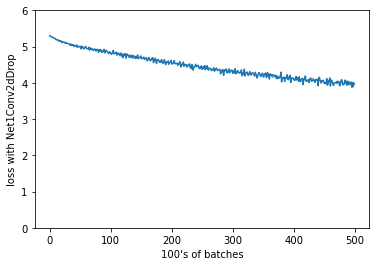

Accuracy of the network on the train images: 27.713654223968565
Accuracy of the network on the test images: 8.357169506280313


In [ ]:
loss_model1d, accur_test_model1d, accur_train_model1d = trainModel(Net1Conv2dDropModel, n_epochs=epochs_baseline)

In [ ]:
# nn with 2 Conv2D layer with Dropout

class Net2Conv2dDrop(nn.Module):

    def __init__(self):
        super(Net2Conv2dDrop, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(186624, 1024)
        self.fc1_drop = nn.Dropout(p=0.4)
       
        self.fc2 = nn.Linear(1024, 196)

    # define the feedforward behavior
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))    
        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # final output
        return x

# instantiate and print your Net
Net2Conv2dModelDrop = Net2Conv2dDrop().to(cuda0)
print(Net2Conv2dModelDrop)

Net2Conv2dDrop(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=46656, out_features=1024, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=196, bias=True)
)


Epoch: 1, Batch: 100, Avg. Loss: 5.280935511589051
Epoch: 1, Batch: 200, Avg. Loss: 5.281196365356445
Epoch: 1, Batch: 300, Avg. Loss: 5.279137139320373
Epoch: 1, Batch: 400, Avg. Loss: 5.2772553300857545
Epoch: 1, Batch: 500, Avg. Loss: 5.277307252883912
Epoch: 2, Batch: 100, Avg. Loss: 5.275487008094788
Epoch: 2, Batch: 200, Avg. Loss: 5.27255720615387
Epoch: 2, Batch: 300, Avg. Loss: 5.270043392181396
Epoch: 2, Batch: 400, Avg. Loss: 5.274160838127136
Epoch: 2, Batch: 500, Avg. Loss: 5.272512326240539
Epoch: 3, Batch: 100, Avg. Loss: 5.260194582939148
Epoch: 3, Batch: 200, Avg. Loss: 5.257894582748413
Epoch: 3, Batch: 300, Avg. Loss: 5.256562232971191
Epoch: 3, Batch: 400, Avg. Loss: 5.241116228103638
Epoch: 3, Batch: 500, Avg. Loss: 5.247047777175903
Epoch: 4, Batch: 100, Avg. Loss: 5.208693528175354
Epoch: 4, Batch: 200, Avg. Loss: 5.20485673904419
Epoch: 4, Batch: 300, Avg. Loss: 5.200884361267089
Epoch: 4, Batch: 400, Avg. Loss: 5.214989552497864
Epoch: 4, Batch: 500, Avg. Loss:

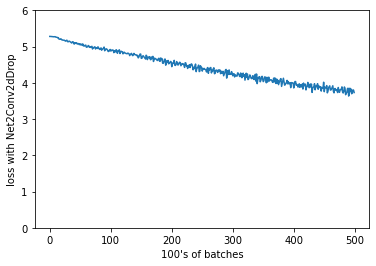

Accuracy of the network on the train images: 32.90766208251473
Accuracy of the network on the test images: 8.344733242134064


In [ ]:
loss_model2d, accur_test_model2d, accur_train_model2d = trainModel(Net2Conv2dModelDrop, n_epochs=epochs_baseline)

In [ ]:
# nn with 3 Conv2D layer with Dropout

class Net3Conv2dDrop(nn.Module):

    def __init__(self):
        super(Net3Conv2dDrop, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(86528, 1024)
        self.fc1_drop = nn.Dropout(p=0.4)
       
        self.fc2 = nn.Linear(1024, 196)

    # define the feedforward behavior
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))    
        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # final output
        return x

# instantiate and print your Net
Net3Conv2dModelDrop = Net3Conv2dDrop().to(cuda0)
print(Net3Conv2dModelDrop)

Net3Conv2dDrop(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=10816, out_features=1024, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=196, bias=True)
)


Epoch: 1, Batch: 100, Avg. Loss: 5.278793802261353
Epoch: 1, Batch: 200, Avg. Loss: 5.278703637123108
Epoch: 1, Batch: 300, Avg. Loss: 5.279380168914795
Epoch: 1, Batch: 400, Avg. Loss: 5.279411993026733
Epoch: 1, Batch: 500, Avg. Loss: 5.279234085083008
Epoch: 2, Batch: 100, Avg. Loss: 5.277463784217835
Epoch: 2, Batch: 200, Avg. Loss: 5.277948975563049
Epoch: 2, Batch: 300, Avg. Loss: 5.277609782218933
Epoch: 2, Batch: 400, Avg. Loss: 5.277844161987304
Epoch: 2, Batch: 500, Avg. Loss: 5.2784465885162355
Epoch: 3, Batch: 100, Avg. Loss: 5.27646683216095
Epoch: 3, Batch: 200, Avg. Loss: 5.276135778427124
Epoch: 3, Batch: 300, Avg. Loss: 5.2768955373764035
Epoch: 3, Batch: 400, Avg. Loss: 5.276869578361511
Epoch: 3, Batch: 500, Avg. Loss: 5.2788238430023195
Epoch: 4, Batch: 100, Avg. Loss: 5.275855751037597
Epoch: 4, Batch: 200, Avg. Loss: 5.274083662033081
Epoch: 4, Batch: 300, Avg. Loss: 5.274044160842895
Epoch: 4, Batch: 400, Avg. Loss: 5.2762252140045165
Epoch: 4, Batch: 500, Avg. L

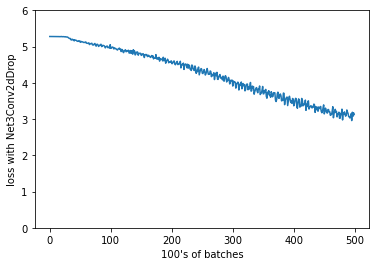

Accuracy of the network on the train images: 39.48919449901768
Accuracy of the network on the test images: 7.648302449944037


In [ ]:
loss_model3d, accur_test_model3d, accur_train_model3d = trainModel(Net3Conv2dModelDrop, n_epochs=epochs_baseline)

In [ ]:
# nn with 4 Conv2D layer with DropOut

class Net4Conv2dDrop(nn.Module):

    def __init__(self):
        super(Net4Conv2dDrop, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.conv4 = nn.Conv2d(128, 256, 3)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(36864, 1024)
        self.fc1_drop = nn.Dropout(p=0.4)
       
        self.fc2 = nn.Linear(1024, 196)

    # define the feedforward behavior
    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x))) 
        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # final output
        return x

# instantiate and print your Net
Net4Conv2dModelDrop = Net4Conv2dDrop().to(cuda0)
print(Net4Conv2dModelDrop)

Net4Conv2dDrop(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=196, bias=True)
)


Epoch: 1, Batch: 100, Avg. Loss: 5.278408365249634
Epoch: 1, Batch: 200, Avg. Loss: 5.279500370025635
Epoch: 1, Batch: 300, Avg. Loss: 5.277803726196289
Epoch: 1, Batch: 400, Avg. Loss: 5.278129281997681
Epoch: 1, Batch: 500, Avg. Loss: 5.279375410079956
Epoch: 2, Batch: 100, Avg. Loss: 5.27843138217926
Epoch: 2, Batch: 200, Avg. Loss: 5.277716708183289
Epoch: 2, Batch: 300, Avg. Loss: 5.278126831054688
Epoch: 2, Batch: 400, Avg. Loss: 5.278685622215271
Epoch: 2, Batch: 500, Avg. Loss: 5.278525586128235
Epoch: 3, Batch: 100, Avg. Loss: 5.277870507240295
Epoch: 3, Batch: 200, Avg. Loss: 5.277403883934021
Epoch: 3, Batch: 300, Avg. Loss: 5.277722177505493
Epoch: 3, Batch: 400, Avg. Loss: 5.27800033569336
Epoch: 3, Batch: 500, Avg. Loss: 5.2786718845367435
Epoch: 4, Batch: 100, Avg. Loss: 5.277263803482056
Epoch: 4, Batch: 200, Avg. Loss: 5.2767880296707155
Epoch: 4, Batch: 300, Avg. Loss: 5.278341107368469
Epoch: 4, Batch: 400, Avg. Loss: 5.277627415657044
Epoch: 4, Batch: 500, Avg. Loss

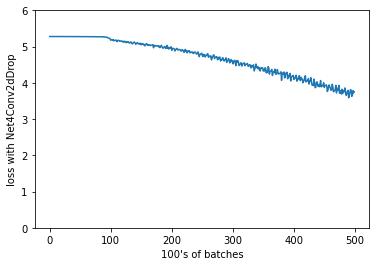

Accuracy of the network on the train images: 25.282416502946955
Accuracy of the network on the test images: 6.0440243750777265


In [ ]:
loss_model4d, accur_test_model4d, accur_train_model4d = trainModel(Net4Conv2dModelDrop, n_epochs=epochs_baseline)

#### Saving Models with DropOut

In [ ]:
# Saving models
torch.save(Net1Conv2dDropModel, DATA_FOLDER+'models/Net1Conv2dDropModel.pth')
torch.save(Net2Conv2dModelDrop, DATA_FOLDER+'models/Net2Conv2dModelDrop.pth')
torch.save(Net3Conv2dModelDrop, DATA_FOLDER+'models/Net3Conv2dModelDrop.pth')
torch.save(Net4Conv2dModelDrop, DATA_FOLDER+'models/Net4Conv2dModelDrop.pth')

In [ ]:
# loading models
'''
Net1Conv2dDropModel = torch.load(DATA_FOLDER+'models/Net1Conv2dDropModel.pth')
Net1Conv2dDropModel.eval()
Net2Conv2dModelDrop = torch.load(DATA_FOLDER+'models/Net2Conv2dModelDrop.pth')
Net2Conv2dModelDrop.eval()
Net3Conv2dDropModel = torch.load(DATA_FOLDER+'models/Net3Conv2dModelDrop.pth')
Net3Conv2dDropModel.eval()
Net4Conv2dDropModel = torch.load(DATA_FOLDER+'models/Net4Conv2dModelDrop.pth')
Net4Conv2dDropModel.eval()
'''

Net4Conv2dDrop(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=196, bias=True)
)

In [ ]:
#a1 = accuracyOnTrainModel(Net1Conv2dDropModel)

Accuracy of the network on the train images: 27.271611001964637


In [ ]:
'''
a2 = accuracyOnTrainModel(Net2Conv2dModelDrop)
a3 = accuracyOnTrainModel(Net3Conv2dModelDrop)
a4 = accuracyOnTrainModel(Net4Conv2dModelDrop)
'''

Accuracy of the network on the train images: 33.0918467583497
Accuracy of the network on the train images: 38.470039292730846
Accuracy of the network on the train images: 25.675343811394892


In [ ]:
'''
b1 = accuracyOnTestModel(Net1Conv2dDropModel)
b2 = accuracyOnTestModel(Net2Conv2dModelDrop)
b3 = accuracyOnTestModel(Net3Conv2dModelDrop)
b4 = accuracyOnTestModel(Net4Conv2dModelDrop)
'''

Accuracy of the network on the test images: 8.357169506280313
Accuracy of the network on the test images: 8.344733242134064
Accuracy of the network on the test images: 7.648302449944037
Accuracy of the network on the test images: 6.0440243750777265


In [ ]:
# dictionary of lists  
'''
dict_accu_2 = [{'Net1Conv2dModelDrop': a1,
               'Net2Conv2dModelDrop': a2,
               'Net3Conv2dModelDrop': a3,
               'Net4Conv2dModelDrop': a3},
               
               {'Net1Conv2dModelDrop': b1,
               'Net2Conv2dModelDrop': b2,
               'Net3Conv2dModelDrop': b3,
               'Net4Conv2dModelDrop': b4}]


accu_drop_models = pd.DataFrame(dict_accu_2)

accu_drop_models.to_csv(DATA_FOLDER+r'models/accu_drop_models.csv', index=False, header=True)
'''

In [ ]:
# dictionary of lists  
dict_accu_2 = [{'Net1Conv2dModelDrop': accur_train_model1d,
               'Net2Conv2dModelDrop': accur_train_model2d,
               'Net3Conv2dModelDrop': accur_train_model3d,
               'Net4Conv2dModelDrop': accur_train_model4d},
               
               {'Net1Conv2dModelDrop': accur_test_model1d,
               'Net2Conv2dModelDrop': accur_test_model2d,
               'Net3Conv2dModelDrop': accur_test_model3d,
               'Net4Conv2dModelDrop': accur_test_model4d}]


accu_drop_models = pd.DataFrame(dict_accu_2)
accu_drop_models.to_csv(DATA_FOLDER+r'models/accu_drop_models.csv', index=False, header=True)

In [ ]:
accu_drop_models = pd.read_csv(DATA_FOLDER+'models/accu_drop_models.csv')
accu_drop_models

,Net1Conv2dModelDrop,Net2Conv2dModelDrop,Net3Conv2dModelDrop,Net4Conv2dModelDrop
0,27.271611,33.091847,38.470039,38.470039
1,8.357170,8.344733,7.648302,6.044024


In [ ]:
# dictionary of lists  
dict_loss = {'Net1Conv2dDropModel': loss_model1d,
        'Net2Conv2dModelDrop': loss_model2d,
        'Net3Conv2dModelDrop': loss_model3d,
        'Net4Conv2dModelDrop': loss_model4d}  
    
loss_drop_models = pd.DataFrame(dict_loss) 
loss_drop_models

NameError: name 'loss_model1d' is not defined

In [ ]:
loss_drop_models = pd.read_csv(DATA_FOLDER+'models/loss_drop_models.csv')
loss_drop_models

,Net1Conv2dDropModel,Net2Conv2dModelDrop,Net3Conv2dModelDrop,Net4Conv2dModelDrop
0,5.301519,5.280936,5.279399,5.277567
1,5.277965,5.281196,5.279009,5.277987
2,5.275216,5.279137,5.277797,5.279000
3,5.272904,5.277255,5.278446,5.279399
4,5.266810,5.277307,5.279233,5.278752
...,...,...,...,...
495,3.882162,3.698799,4.027034,4.485151
496,4.001185,3.735113,4.005288,4.564720
497,3.887265,3.805522,4.072840,4.537001
498,4.007294,3.799345,4.035227,4.447174


In [ ]:
accu_drop_models['Net1Conv2dModelDrop'][0]

27.27161100196464

#### Visualizing Model without/with DropOut

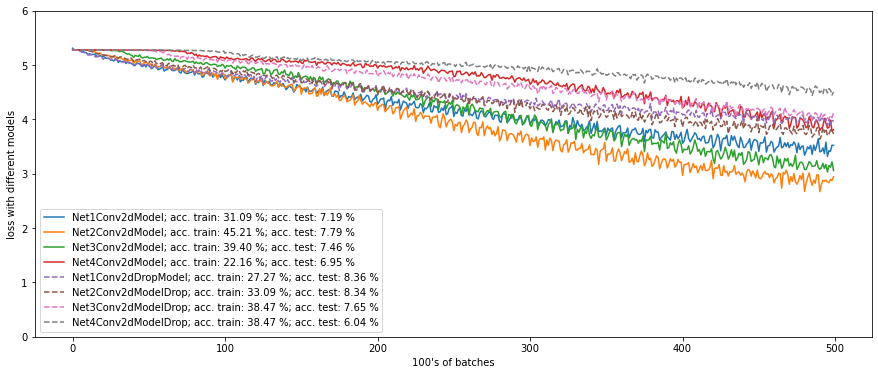

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(load_stock['Net1Conv2dModel'], label='Net1Conv2dModel' + '; acc. train: {:0.2f} %'.format(accu_stock_models['Net1Conv2dModel'][1])+'; acc. test: {:0.2f} %'.format(accu_stock_models['Net1Conv2dModel'][0]))
plt.plot(load_stock['Net2Conv2dModel'], label="Net2Conv2dModel" + '; acc. train: {:0.2f} %'.format(accu_stock_models['Net2Conv2dModel'][1])+'; acc. test: {:0.2f} %'.format(accu_stock_models['Net2Conv2dModel'][0]))
plt.plot(load_stock['Net3Conv2dModel'], label="Net3Conv2dModel" + '; acc. train: {:0.2f} %'.format(accu_stock_models['Net3Conv2dModel'][1])+'; acc. test: {:0.2f} %'.format(accu_stock_models['Net3Conv2dModel'][0]))
plt.plot(load_stock['Net4Conv2dModel'], label="Net4Conv2dModel" + '; acc. train: {:0.2f} %'.format(accu_stock_models['Net4Conv2dModel'][1])+'; acc. test: {:0.2f} %'.format(accu_stock_models['Net4Conv2dModel'][0]))

plt.plot(loss_drop_models['Net1Conv2dDropModel'], label='Net1Conv2dDropModel' + '; acc. train: {:0.2f} %'.format(accu_drop_models['Net1Conv2dModelDrop'][0])+'; acc. test: {:0.2f} %'.format(accu_drop_models['Net1Conv2dModelDrop'][1]), linestyle='dashed')
plt.plot(loss_drop_models['Net2Conv2dModelDrop'], label='Net2Conv2dModelDrop' + '; acc. train: {:0.2f} %'.format(accu_drop_models['Net2Conv2dModelDrop'][0])+'; acc. test: {:0.2f} %'.format(accu_drop_models['Net2Conv2dModelDrop'][1]), linestyle='dashed')
plt.plot(loss_drop_models['Net3Conv2dModelDrop'], label='Net3Conv2dModelDrop' + '; acc. train: {:0.2f} %'.format(accu_drop_models['Net3Conv2dModelDrop'][0])+'; acc. test: {:0.2f} %'.format(accu_drop_models['Net3Conv2dModelDrop'][1]), linestyle='dashed')
plt.plot(loss_drop_models['Net4Conv2dModelDrop'], label='Net4Conv2dModelDrop' + '; acc. train: {:0.2f} %'.format(accu_drop_models['Net4Conv2dModelDrop'][0])+'; acc. test: {:0.2f} %'.format(accu_drop_models['Net4Conv2dModelDrop'][1]), linestyle='dashed')

plt.xlabel('100\'s of batches')
plt.ylabel('loss with different models')
plt.ylim(0, 6) # consistent scale
plt.legend()
plt.show()

#### f. Apply BatchNorm layers. Train and evaluate the model. Compare with the previous versions. What has happened? Why?

BatchNorm helps to solve problem with vanished gradients in NN. It helps to increase model accuracy on evaluation, and speeds up trainig process.

Visual comparasion below after training.

In [ ]:
# nn with 4 Conv2D layer with DropOut with BatchNorm

class Net4Conv2dBatch(nn.Module):

    def __init__(self):
        super(Net4Conv2dBatch, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(36864, 1024)
        self.fc1_drop = nn.Dropout(p=0.4)
       
        self.fc2 = nn.Linear(1024, 196)

    # define the feedforward behavior
    def forward(self, x):

        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = x.view(x.size(0), -1)
        
        # two linear layers with dropout in between
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)
        
        # final output
        return x

# instantiate and print your Net
Net4Conv2dBatchModel = Net4Conv2dBatch().to(cuda0)
print(Net4Conv2dBatchModel)

Net4Conv2dBatch(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=1024, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=196, bias=True)
)


Epoch: 1, Batch: 100, Avg. Loss: 5.47700370311737
Epoch: 1, Batch: 200, Avg. Loss: 5.323735780715943
Epoch: 1, Batch: 300, Avg. Loss: 5.299125828742981
Epoch: 1, Batch: 400, Avg. Loss: 5.283964881896972
Epoch: 1, Batch: 500, Avg. Loss: 5.2509690952301025
Epoch: 2, Batch: 100, Avg. Loss: 5.179455552101135
Epoch: 2, Batch: 200, Avg. Loss: 5.189540724754334
Epoch: 2, Batch: 300, Avg. Loss: 5.167149615287781
Epoch: 2, Batch: 400, Avg. Loss: 5.173978567123413
Epoch: 2, Batch: 500, Avg. Loss: 5.170926547050476
Epoch: 3, Batch: 100, Avg. Loss: 5.103095774650574
Epoch: 3, Batch: 200, Avg. Loss: 5.141511883735657
Epoch: 3, Batch: 300, Avg. Loss: 5.145954194068909
Epoch: 3, Batch: 400, Avg. Loss: 5.133859496116639
Epoch: 3, Batch: 500, Avg. Loss: 5.105481781959534
Epoch: 4, Batch: 100, Avg. Loss: 5.069506940841674
Epoch: 4, Batch: 200, Avg. Loss: 5.047523174285889
Epoch: 4, Batch: 300, Avg. Loss: 5.0180421066284175
Epoch: 4, Batch: 400, Avg. Loss: 5.051303043365478
Epoch: 4, Batch: 500, Avg. Los

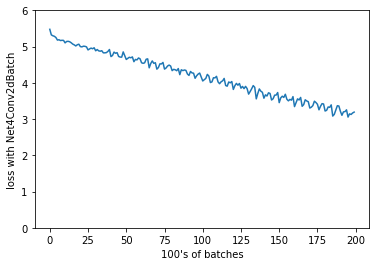

Accuracy of the network on the train images: 47.08988212180746
Accuracy of the network on the test images: 16.726775276706878


In [ ]:
loss_model4b, accur_test_modelb, accur_train_model4b = trainModel(Net4Conv2dBatchModel, n_epochs=epochs_baseline)

In [ ]:
# Saving models
torch.save(Net4Conv2dBatchModel, DATA_FOLDER+'models/Net4Conv2dBatchModel.pth')

In [ ]:
# loading models
'''
Net4Conv2dBatchModel = torch.load(DATA_FOLDER+'models/Net4Conv2dBatchModel.pth')
Net4Conv2dBatchModel.eval()
'''

In [ ]:
'''
accur_train_model1b =  accuracyOnTrainModel(Net4Conv2dBatchModel)
accur_test_model1b = accuracyOnTestModel(Net4Conv2dBatchModel)
'''

Accuracy of the network on the train images: 46.63555992141454
Accuracy of the network on the test images: 16.726775276706878


In [ ]:
# dictionary of lists  
dict_accu_3 = [{'Net4Conv2dBatchModel': accur_train_model1b},
               
               {'Net4Conv2dBatchModel': accur_test_model1b}]


accu_batch_models = pd.DataFrame(dict_accu_3)
accu_batch_models.to_csv(DATA_FOLDER+r'models/accu_batch_models.csv', index=False, header=True)

In [ ]:
accu_batch_models = pd.read_csv(DATA_FOLDER+'models/accu_batch_models.csv')
accu_batch_models

,Net4Conv2dBatchModel
0,46.635560
1,16.726775


In [ ]:
# dictionary of lists  
dict_loss = {'Net4Conv2dBatchModel': loss_model4b,}  
    
loss_batch_models = pd.DataFrame(dict_loss) 
loss_batch_models.to_csv(DATA_FOLDER+r'models/loss_batch_models.csv', index=False, header=True)
loss_batch_models

,Net4Conv2dBatchModel
0,5.477004
1,5.323736
2,5.299126
3,5.283965
4,5.250969
...,...
195,3.055311
196,3.144034
197,3.127247
198,3.168464


In [ ]:
loss_batch_models = pd.read_csv(DATA_FOLDER+'models/loss_batch_models.csv')
loss_batch_models

,Net4Conv2dBatchModel
0,5.477004
1,5.323736
2,5.299126
3,5.283965
4,5.250969
...,...
195,3.055311
196,3.144034
197,3.127247
198,3.168464


#### Visualizing stock 4conv2d Model, with DropOut, with DropOut&BatchNorm

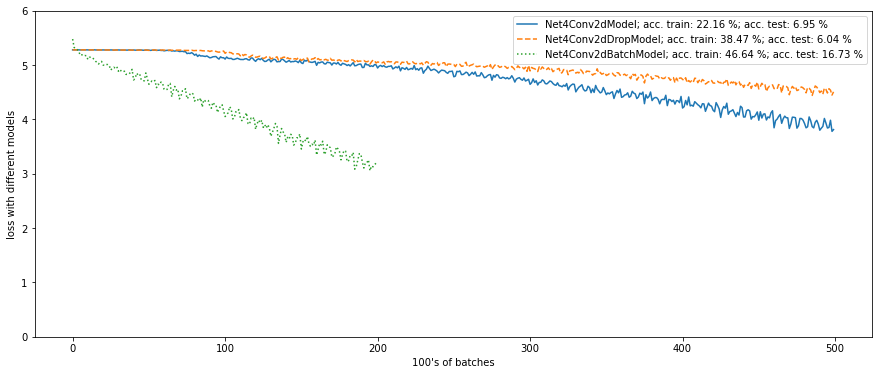

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(load_stock['Net4Conv2dModel'], label='Net4Conv2dModel' + '; acc. train: {:0.2f} %'.format(accu_stock_models['Net4Conv2dModel'][1])+'; acc. test: {:0.2f} %'.format(accu_stock_models['Net4Conv2dModel'][0]))

plt.plot(loss_drop_models['Net4Conv2dModelDrop'], label='Net4Conv2dDropModel' + '; acc. train: {:0.2f} %'.format(accu_drop_models['Net4Conv2dModelDrop'][0])+'; acc. test: {:0.2f} %'.format(accu_drop_models['Net4Conv2dModelDrop'][1]), linestyle='dashed')

plt.plot(loss_batch_models['Net4Conv2dBatchModel'], label='Net4Conv2dBatchModel' + '; acc. train: {:0.2f} %'.format(accu_batch_models['Net4Conv2dBatchModel'][0])+'; acc. test: {:0.2f} %'.format(accu_batch_models['Net4Conv2dBatchModel'][1]), linestyle='dotted')

plt.xlabel('100\'s of batches')
plt.ylabel('loss with different models')
plt.ylim(0, 6) # consistent scale
plt.legend()
plt.show()

#### g. What model configuration is optimal? Why?

Last model with 4 conv2d Layer with BatchNorm is Optimal. Configuration with BatchNorm Layers after each convolution layerto solve vanishing gradient problem, preventing overfitting, accuracy on evaluation is higher on same number of epochs.

#### h. What is the optimal layer sequence? Why?

Optimal layer sequence is (on convolution phase)

- Convolution
- BatchNorm
- Pooling

Than repeat this several times. Number of kernels in convolution layers should be increased on every Layer (starts from 32, than 64, than 126 etc.)


On last phase, after tensors flattern stage, NN may contains DropOut Layers to prevent overfitting.

My optimal sequence is: 

  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=1024, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=196, bias=True)

#### i. Apply image augmentation (RandomFlip, RandomRotation, RandomZoom, RandomBrightness, etc.). Train and evaluate the model. Compare with the previous versions. What has happened? Why?

Applying image augmentations helps to extend training dataset with new exaples. It solves problem with small datasets and allowing to prevent overfitting model. Very usefull technics)) Helps a lot.

Visual comparasion is below after training

In [ ]:
data_transform_train_aug = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor()
    ])

data_transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ])
        
batch_size = 16

cars_dataset_train = datasets.ImageFolder(root=DATA_FOLDER+'/train',
                                           transform=data_transform_train_aug)
cars_dataset_test = datasets.ImageFolder(root=DATA_FOLDER+'/test',
                                           transform=data_transform_test)

train_loader = torch.utils.data.DataLoader(cars_dataset_train,
                                             batch_size, shuffle=True, num_workers=16)
test_loader = torch.utils.data.DataLoader(cars_dataset_test,
                                             batch_size, shuffle=True, num_workers=16)

In [ ]:
Net4Conv2dAugModel = Net4Conv2dBatch().to(cuda0)
print(Net4Conv2dAugModel)

Net4Conv2dBatch(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=36864, out_features=1024, bias=True)
  (fc1_drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=1024, out_features=196, bias=True)
)


Epoch: 1, Batch: 100, Avg. Loss: 5.528506002426147
Epoch: 1, Batch: 200, Avg. Loss: 5.3585559225082395
Epoch: 1, Batch: 300, Avg. Loss: 5.290250005722046
Epoch: 1, Batch: 400, Avg. Loss: 5.290751128196717
Epoch: 1, Batch: 500, Avg. Loss: 5.274918389320374
Epoch: 2, Batch: 100, Avg. Loss: 5.2212974643707275
Epoch: 2, Batch: 200, Avg. Loss: 5.216760010719299
Epoch: 2, Batch: 300, Avg. Loss: 5.254094295501709
Epoch: 2, Batch: 400, Avg. Loss: 5.223981795310974
Epoch: 2, Batch: 500, Avg. Loss: 5.222103400230408
Epoch: 3, Batch: 100, Avg. Loss: 5.209350204467773
Epoch: 3, Batch: 200, Avg. Loss: 5.16869204044342
Epoch: 3, Batch: 300, Avg. Loss: 5.187169361114502
Epoch: 3, Batch: 400, Avg. Loss: 5.169132781028748
Epoch: 3, Batch: 500, Avg. Loss: 5.191956062316894
Epoch: 4, Batch: 100, Avg. Loss: 5.160585298538208
Epoch: 4, Batch: 200, Avg. Loss: 5.162577829360962
Epoch: 4, Batch: 300, Avg. Loss: 5.148523826599121
Epoch: 4, Batch: 400, Avg. Loss: 5.145301122665405
Epoch: 4, Batch: 500, Avg. Los

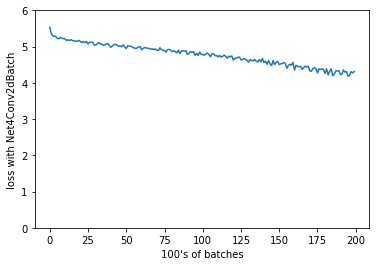

Accuracy of the network on the train images: 16.92043222003929
Accuracy of the network on the test images: 13.244621315756747


In [ ]:
loss_modela, accur_test_modela, accur_train_model4a = trainModel(Net4Conv2dAugModel, n_epochs=epochs_baseline)

In [ ]:
# Saving models
torch.save(Net4Conv2dAugModel, DATA_FOLDER+'models/Net4Conv2dAugModel.pth')

In [ ]:
# loading models
'''
Net4Conv2dAugModel = torch.load(DATA_FOLDER+'models/Net4Conv2dAugModel.pth')
Net4Conv2dAugModel.eval()
'''

In [ ]:
# dictionary of lists  
dict_accu_5 = [{'Net4Conv2dAugModel': accur_train_model4a},
               
               {'Net4Conv2dAugModel': accur_test_modela}]


accu_aug_models = pd.DataFrame(dict_accu_5)
accu_aug_models.to_csv(DATA_FOLDER+r'models/accu_aug_models.csv', index=False, header=True)

In [ ]:
accu_aug_models = pd.read_csv(DATA_FOLDER+'models/accu_aug_models.csv')
accu_aug_models

,Net4Conv2dAugModel
0,13.244621
1,16.920432


In [ ]:
# dictionary of lists  
dict_loss = {'Net4Conv2dAugModel': loss_modela,}  
    
loss_aug_models = pd.DataFrame(dict_loss) 
loss_aug_models.to_csv(DATA_FOLDER+r'models/loss_aug_models.csv', index=False, header=True)
loss_aug_models

,Net4Conv2dAugModel
0,5.528506
1,5.358556
2,5.290250
3,5.290751
4,5.274918
...,...
195,4.185192
196,4.205711
197,4.310595
198,4.273647


In [ ]:
loss_aug_models = pd.read_csv(DATA_FOLDER+'models/loss_aug_models.csv')
loss_aug_models

,Net4Conv2dAugModel
0,5.528506
1,5.358556
2,5.290250
3,5.290751
4,5.274918
...,...
195,4.185192
196,4.205711
197,4.310595
198,4.273647


#### Visualizing stock 4conv2d Model, with DropOut, with DropOut&BatchNorm, with Augmentation

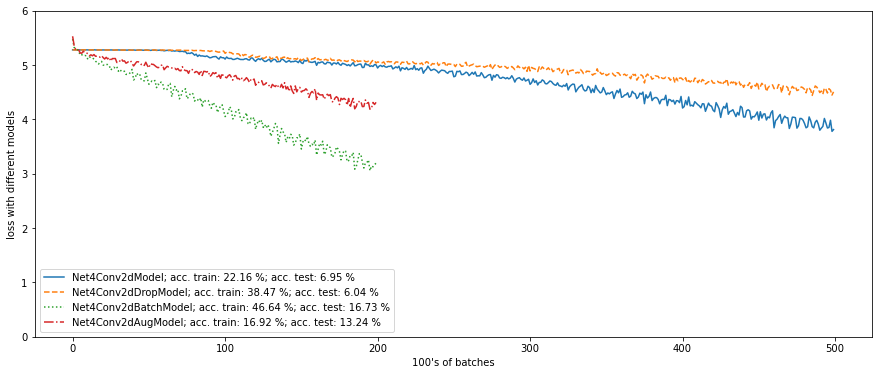

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(load_stock['Net4Conv2dModel'], label='Net4Conv2dModel' + '; acc. train: {:0.2f} %'.format(accu_stock_models['Net4Conv2dModel'][1])+'; acc. test: {:0.2f} %'.format(accu_stock_models['Net4Conv2dModel'][0]))

plt.plot(loss_drop_models['Net4Conv2dModelDrop'], label='Net4Conv2dDropModel' + '; acc. train: {:0.2f} %'.format(accu_drop_models['Net4Conv2dModelDrop'][0])+'; acc. test: {:0.2f} %'.format(accu_drop_models['Net4Conv2dModelDrop'][1]), linestyle='dashed')

plt.plot(loss_batch_models['Net4Conv2dBatchModel'], label='Net4Conv2dBatchModel' + '; acc. train: {:0.2f} %'.format(accu_batch_models['Net4Conv2dBatchModel'][0])+'; acc. test: {:0.2f} %'.format(accu_batch_models['Net4Conv2dBatchModel'][1]), linestyle='dotted')

plt.plot(loss_aug_models['Net4Conv2dAugModel'], label='Net4Conv2dAugModel' + '; acc. train: {:0.2f} %'.format(accu_aug_models['Net4Conv2dAugModel'][1])+'; acc. test: {:0.2f} %'.format(accu_aug_models['Net4Conv2dAugModel'][0]), linestyle='dashdot')

plt.xlabel('100\'s of batches')
plt.ylabel('loss with different models')
plt.ylim(0, 6) # consistent scale
plt.legend()
plt.show()

### Training 1000 epochs with Last model

Epoch: 1, Batch: 100, Avg. Loss: 4.123756139278412
Epoch: 1, Batch: 200, Avg. Loss: 4.059859557151794
Epoch: 1, Batch: 300, Avg. Loss: 4.045826048851013
Epoch: 1, Batch: 400, Avg. Loss: 4.077694451808929
Epoch: 1, Batch: 500, Avg. Loss: 4.035779473781585
Epoch: 2, Batch: 100, Avg. Loss: 3.9600764656066896
Epoch: 2, Batch: 200, Avg. Loss: 3.994443962574005
Epoch: 2, Batch: 300, Avg. Loss: 4.017124269008637
Epoch: 2, Batch: 400, Avg. Loss: 3.933347647190094
Epoch: 2, Batch: 500, Avg. Loss: 3.9365011644363403
Epoch: 3, Batch: 100, Avg. Loss: 3.786672503948212
Epoch: 3, Batch: 200, Avg. Loss: 3.844631700515747
Epoch: 3, Batch: 300, Avg. Loss: 3.8642098903656006
Epoch: 3, Batch: 400, Avg. Loss: 3.8733846092224122
Epoch: 3, Batch: 500, Avg. Loss: 3.801219024658203
Epoch: 4, Batch: 100, Avg. Loss: 3.7105418610572816
Epoch: 4, Batch: 200, Avg. Loss: 3.7734383797645568
Epoch: 4, Batch: 300, Avg. Loss: 3.788085720539093
Epoch: 4, Batch: 400, Avg. Loss: 3.736771523952484
Epoch: 4, Batch: 500, Avg

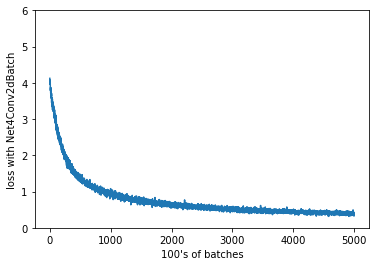

Accuracy of the network on the train images: 90.68025540275049
Accuracy of the network on the test images: 41.92264643701032


In [ ]:
loss_modela, accur_test_modela, accur_train_model4a = trainModel(Net4Conv2dAugModel, n_epochs=1000)

In [ ]:
# Saving models
torch.save(Net4Conv2dAugModel, DATA_FOLDER+'models/Net4Conv2dAugModelTrain1000.pth')

In [ ]:
# loading models
'''
Net4Conv2dAugModel = torch.load(DATA_FOLDER+'models/Net4Conv2dAugModelTrain1000.pth')
Net4Conv2dAugModel.eval()
'''

"\nNet4Conv2dAugModel = torch.load(DATA_FOLDER+'models/Net4Conv2dAugModelTrain1000.pth')\nNet4Conv2dAugModel.eval()\n"

In [ ]:
# dictionary of lists  
dict_loss = {'Net4Conv2dAugModel': loss_modela}  
    
loss_aug_models_1000 = pd.DataFrame(dict_loss) 
loss_aug_models_1000.to_csv(DATA_FOLDER+r'models/loss_aug_models_1000.csv', index=False, header=True)
loss_aug_models_1000

,Net4Conv2dAugModel
0,4.123756
1,4.059860
2,4.045826
3,4.077694
4,4.035779
...,...
4995,0.428491
4996,0.323383
4997,0.390517
4998,0.367287


#### j. Visualize filters and activation maps of a convolutional layer of your choice. What features each filter has learned to extract? Are they reasonable?

Yes they a reasonable. Kernels contains covolutions, which hels to found small features on images - little edges, shapes, vertical and horizontal lines.

First convolutional layer


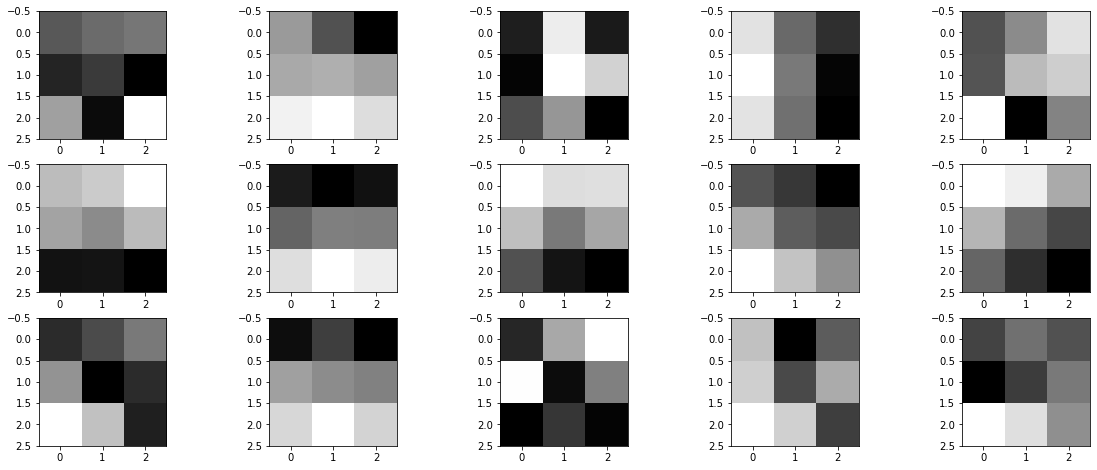

In [ ]:
# Get the weights in the first conv layer
weights = Net4Conv2dAugModel.conv1.weight.data
w = weights.cpu().numpy()

# for 10 filters
fig=plt.figure(figsize=(20, 8))
columns = 5
rows = 3
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(w[i][0], cmap='gray')
    
print('First convolutional layer')
plt.show()

weights = Net4Conv2dAugModel.conv2.weight.data
w = weights.cpu().numpy()

In [ ]:
pip install opencv-python

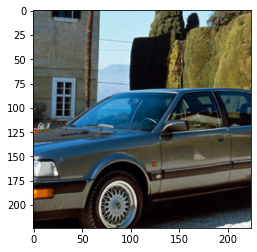

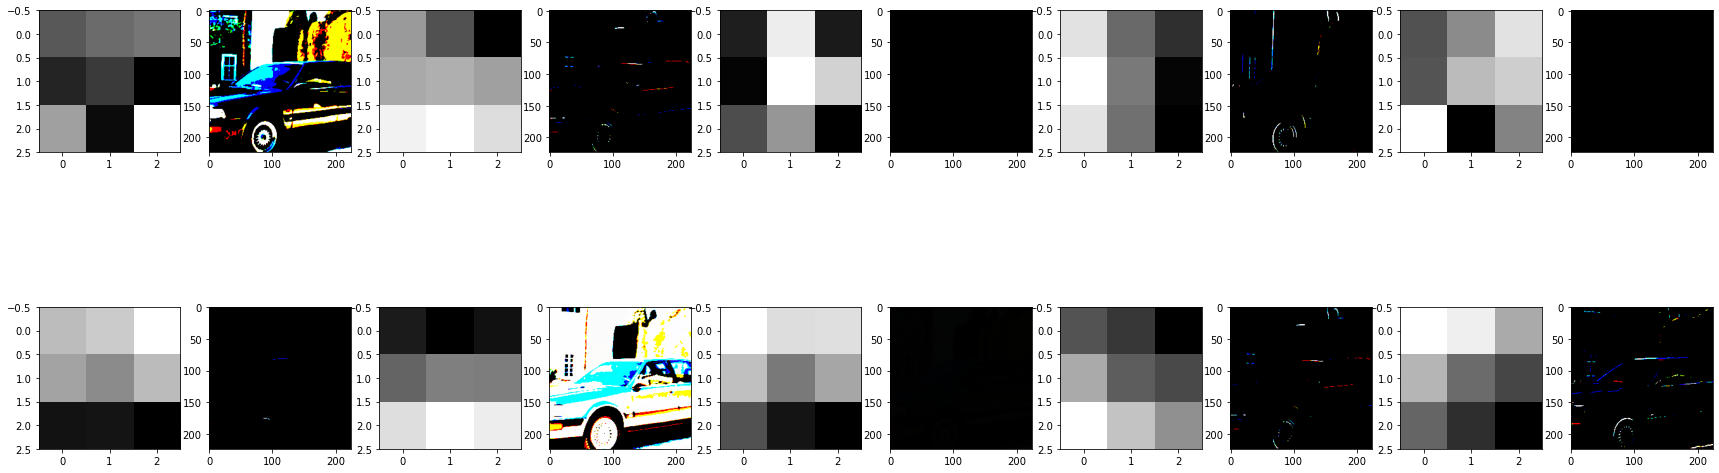

In [ ]:
# obtain one batch of testing images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 3
img = np.squeeze(images[idx]).transpose((1, 2, 0))
#img = np.clip(img, 0, 1)

# Use OpenCV's filter2D function 
# apply a specific set of filter weights (like the one's displayed above) to the test image

import cv2
plt.imshow(img, cmap='gray')

weights = Net4Conv2dAugModel.conv1.weight.data
w = weights.cpu().numpy()

# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0]).astype(np.uint8)
        plt.imshow(c, cmap='gray')
plt.show()

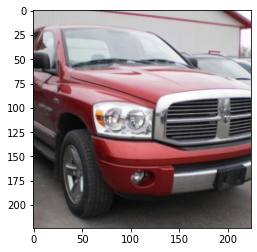

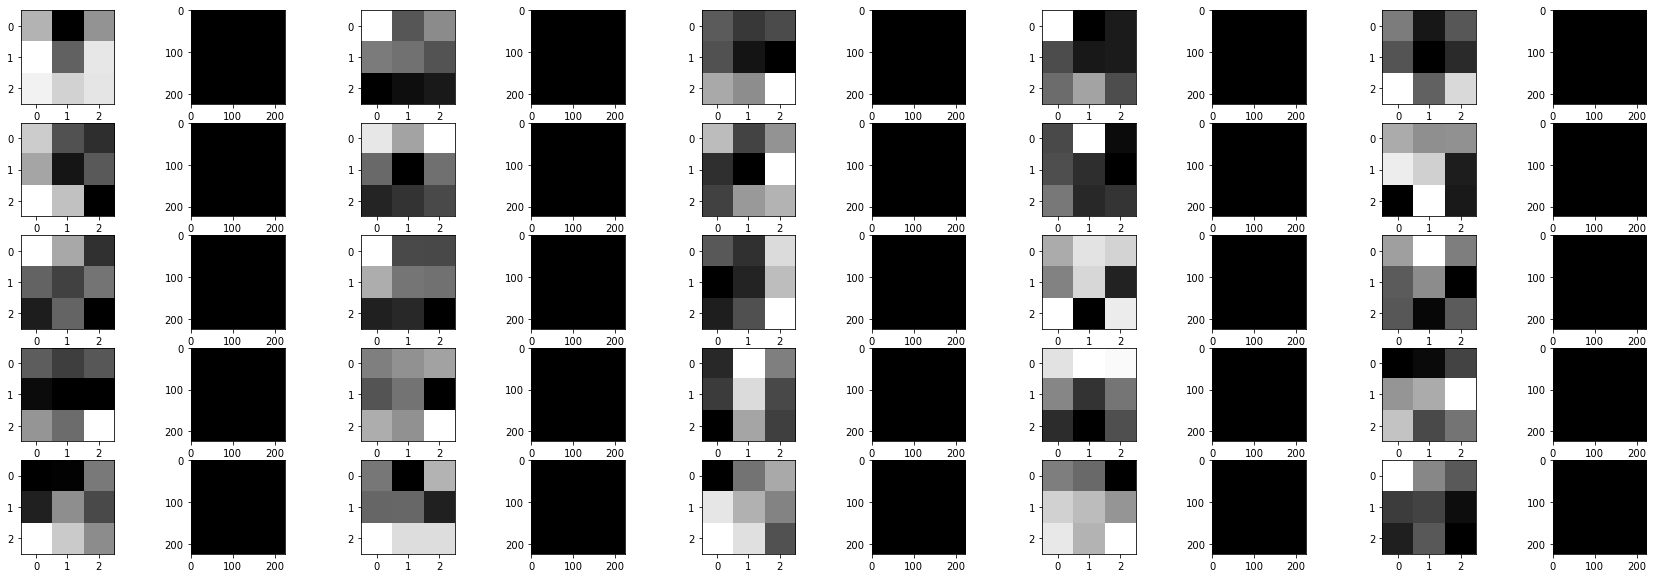

In [ ]:
# obtain one batch of testing images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy()

# select an image by index
idx = 3
img = np.squeeze(images[idx]).transpose((1, 2, 0))

# Use OpenCV's filter2D function 
# apply a specific set of filter weights (like the one's displayed above) to the test image

import cv2
plt.imshow(img, cmap='gray')

weights = Net4Conv2dAugModel.conv2.weight.data
w = weights.cpu().numpy()

# 1. first conv layer
# for 10 filters
fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 5
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0]).astype(np.uint8)
        plt.imshow(c, cmap='gray')
plt.show()